# ニューラルネットワークの学習

## データ駆動

機械学習においてはデータが命である

データからパターンを見つけ出し、データから答えを導く出すのが機械学習の本質である

ここで、入力データからデータの本質的なパターンを導き出す変換器を**特徴量**と呼ぶ

### 特徴量の抽出の歴史
最も単純な分類である線形分類においては、特徴量を抽出する必要はなく、入力データから有限回の学習により問題を解くことが可能だった

これは最初に行ったパーセプトロンによるAND, OR等の演算子の実装において証明されたように「パーセプトロンの収束原理」として知られている

一方、非線形分類問題は入力データからの自動的な学習が不可能であり、特徴量を抽出する必要が出てきた

当初は、特徴量の抽出からデータの学習（アルゴリズムの実装）まで全て人の手で行われており、このモデルは**エキスパートシステム**と呼ばれる

その後、特徴量はデータサイエンティストと呼ばれる人々によって抽出されるようになり、抽出された特徴量を**機械学習アルゴリズム**（SVM, kNNなど）を用いて自動的に学習することが可能になった

そして近年話題となった**ニューラルネットワーク（ディープラーニング）**においては、特徴量の抽出からデータの学習までを全てコンピュータによって行われるようになっている

![machine_learning_history](./img/machine_learning_history.png)

### パラメータの最適化と損失関数
機械学習およびニューラルネットワークにおいては、データの学習とはすなわち**パラメータの最適化**である

例えばニューラルネットワークは、重みとバイアスというパラメータの値を少しずつ変化させ、計算結果が教師データと近い値になるように学習を行っている

この時、計算結果と教師データとの誤差を表現する関数を**損失関数**と呼び、この損失関数を最小化することが学習の目的となる

関数の最小値を求める場合、数学的には**微分**という手法が用いられる

微分値とは「ある瞬間における変化の量」と定義される値のことであり、わかりやすく言えば、グラフの接線の傾きのことである

簡単のため二次関数を例にすると下図の通り、微分値が0になる（接線の傾きが0になる）点が関数の最小値点であり、パラメータの最適点であると考えることができる

![loss_function_optimization](./img/loss_function_optimization.png)

ニューラルネットワークの学習においてはこのように、「損失関数」と「微分」がキーワードとなる

## 微分の実装

微分の数学的な定義は以下のようになる

$$
    \frac{df(x)}{dx} = \lim_{h \to 0}{\frac{f(x+h) - f(x)}{h}}
$$

この式は、関数 $f(x)$ において $x$ が極めて微小な量 $h$ だけ変化したときの $f(x)$ の変化量を表している

ここで $x$ の極めて微小な変化量 $h$ をプログラム的にどう表すかが問題となる

### 数値微分
上記問題の最も単純な解決策は、$h$ に $10^{-50}$ などの極めて小さな値を入れてしまうことである

このような微分手法を**数値微分**と呼ぶ

この実装における注意点として、実装するプログラミング言語の**丸め誤差**を考慮しなければならないことと、数値微分で生じる誤差を極力減らすように工夫しなければならないことが挙げられる

丸め誤差とは、小数の小さな範囲で数値が省略されることで発生する誤差のことで、計算機イプシロンとして定義されており、Juliaにおいては `2.220446049250313e-16` という値になっている

In [5]:
# 計算機イプシロンの取得
eps(Float64)

2.220446049250313e-16

理論上は、上記の値より大きな値を $h$ に設定すればよいが、計算量との兼ね合いから、一般的に $10^{-4}$ に設定すれば大抵の場合で上手く行くとされている

続いて、数値微分によって生じる誤差について考える

数値微分では、「限りなく0に近い値」を「極めて微小な値」と置き換えて実装するため、その分の誤差が生じる

この誤差を極力減らすため、数値微分の実装では**中心差分**という差分をとることが多い

ここで、微分の定義における $f(x+h) - f(x)$ のような差分を**前方差分**と呼ぶが、中心差分では $x$ を中心としてその前後の差分 $f(x+h) - f(x-h)$ をとる

このように差分の平均値を計算することで、誤差を減らすことができる

ここまでの注意点を考慮して数値微分を実装すると以下のようになる

In [1]:
# 数値微分関数
numeric_diff(f, x) = begin
    h = 1e-4 # 10^(-4)
    (f(x + h) - f(x - h)) / 2h # 中心差分から微分値を計算
end

numeric_diff (generic function with 1 method)

In [7]:
"""
@test: 数値微分

例題: f(x) = 0.01x^2 + 0.1x
解析的微分: f'(x) = 0.02x + 0.1
    => f'(5) = 0.2, f'(10) = 0.3
"""
# 例題の設定
f(x) = 0.01x^2 + 0.1x

# 数値微分: f'(5)
## => 0.1999999999990898 ≒ 0.2
println(numeric_diff(f, 5))

# 数値微分: f'(10)
## => 0.2999999999986347 ≒ 0.3
println(numeric_diff(f, 10))

0.1999999999990898
0.2999999999986347


### 偏微分
上記の微分処理では、変数は $x$ のみだったため話は簡単だった

しかし通常、ニューラルネットワークにおいてはパラメータが複数あるため、1変数のみの微分では対応が難しい

そこで、**偏微分**という手法が必要になってくる

ここでは簡単のため、2変数 $x_0, x_1$ で表される以下のような関数を考える

$$
    f(x_0, x_1) = x_0^2 + x_1^2
$$

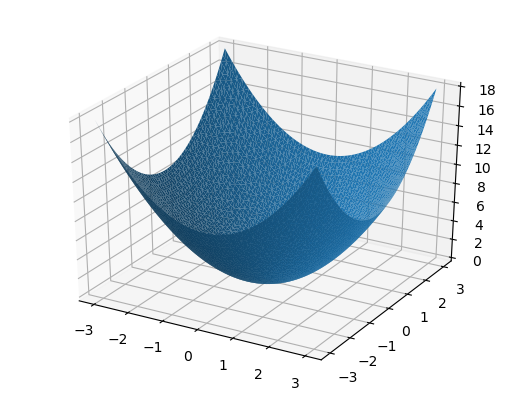

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa50b2a7ba8>

In [1]:
# 2変数関数
f(x0::Float64, x1::Float64) = x0^2 + x1^2

"""
@show: グラフ描画
"""
# PyPlotパッケージ利用
using PyPlot

# 軸準備
x0 = collect(-3.0:0.1:3.0) # x_0: -3.0, -2.9, -2.8, ..., 2.9, 3.0
x1 = collect(-3.0:0.1:3.0) # x_1: -3.0, -2.9, -2.8, ..., 2.9, 3.0

# X軸: [x0 × x0]: 61 x 61 Array{Float64,2}
X = hcat(fill(x0, length(x0))...)

# Y軸: [x1 × x1] の転置行列: 61 x 61 Array{Float64,2}
Y = hcat(fill(x1, length(x1))...)
Y = Y'

# Z軸: grid状にf(x0, x1)計算 = [f.(x0, x1) × f.(x0, x1')]
## => 61 x 61 Array{Float64, 2}
Z = [f(x, y) for x in x0, y in x1]

# グラフ描画用に行列を1次元配列に変換
X = reshape(X, (1, :))[1, :]
Y = reshape(Y, (1, :))[1, :]
Z = reshape(Z, (1, :))[1, :]

# 3Dグラフを描画
surf(X, Y, Z)

このように2つ以上の変数からなる関数に対する微分は、「どの変数に対する微分か」を区別する必要がある

このような微分を**偏微分**と呼ぶ

偏微分では、複数ある変数の中でターゲットとする変数を1つに絞り、他の変数は定数として扱う

In [5]:
"""
@test: 数値微分による偏微分

例題: f(x_0, x_1) = x_0^2 + x_1^2
解析的偏微分: ∂f/∂x_0 = 2x_0 (x_0に対する偏微分)
    x_0 = 3, x_1 = 4 のとき => ∂f/∂x_0 = 2x_0 = 2 * 3 = 6
"""
# 2変数関数
f(x_0::Float64, x_1::Float64) = x_0^2 + x_1^2

# 1変数（x_0）関数として再定義（x_1 = 4 の定数）
g(x_0::Float64) = f(x_0, 4.0)

# 数値微分: x_0 = 3
## => 6.00000000000378 ≒ 6
println(numeric_diff(g, 3.0))

6.00000000000378


In [6]:
"""
@test: 数値微分による偏微分

例題: f(x_0, x_1) = x_0^2 + x_1^2
解析的偏微分: ∂f/∂x_1 = 2x_1 (x_1に対する偏微分)
    x_0 = 3, x_1 = 4 のとき => ∂f/∂x_1 = 2x_1 = 2 * 4 = 8
"""
# 2変数関数
f(x_0::Float64, x_1::Float64) = x_0^2 + x_1^2

# 1変数（x_1）関数として再定義（x_0 = 3 の定数）
g(x_1::Float64) = f(3.0, x_1)

# 数値微分: x_1 = 4
## => 7.999999999999119 ≒ 8
println(numeric_diff(g, 4.0))

7.999999999999119
